<a href="https://colab.research.google.com/github/XaviJunior/SBB/blob/master/project_2/Code/Team_SBB_project_2_Disaster_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !pwd

In [0]:
# !git clone https://github.com/XaviJunior/SBB.git

In [0]:
# cd SBB/project_2/Code
# !ls

# Real or Not? NLP with Disaster Tweets (Kaggle Competition)

In [42]:
from IPython.display import YouTubeVideo
YouTubeVideo("", width=600)

[Link to the GitHub repository](https://github.com/XaviJunior/SBB)

[Link to the YouTube video]()

## Kaggle rank and score

![alt text](https://i.ibb.co/sKGQwh5/nlp-kaggle-rank.png)

Achieved on May 13 2020.

## Contributions

* **Xavier AEBY**: experiments with Doc2Vec, video
* **Tarik BACHA**: experiments with neural networks, EDA, LIME explanations
* **Tanguy BERGUERAND**: cleaning, experiments with various models
* **Frederic SPYCHER**: cleaning, experiments with various models, writing notebook

## Introduction

For our second group project, we were asked to join the [Real or Not? NLP with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started) Kaggle competition. This challenge consists of training a machine learning model that can predict, using **natural language processing** (NLP), whether tweets about **disasters** are genuine.

From the Kaggle website:

_Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies). But, it’s not always clear whether a person’s words are actually announcing a disaster._

Therefore, the **incentive** for such a model is to later build an application that can bolster the monitoring efforts of the aforementioned organizations by helping them to identify actual threats more quickly, and with more accuracy.

## Setting things up

For NLP operations like tokenization, we turned to the powerful Python library **spaCy**. It comes with a pretrained model for English (`en_core_web_sm`).

For machine learning models, we mostly used the toolkit offered by the **scikit-learn** library. Experiments with neural networks were done with **Keras/TensorFlow**.

At the end of the notebook, model explanations are done using **LIME**.

To make sure the environment contains all the necessary libraries, the following `pip` commands can be uncommented and called.

In [0]:
# !pip install keras
# !pip install lime
# !pip install spacy
# !python -m spacy download en_core_web_sm
# !pip install tensorflow
# !pip install wordcloud

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

## The data

The data provided by Kaggle contains more than **10,000 tweets**, for 70% of which we are given the `target` class, i.e. whether they are true (1) or false (0). Each observation from the training data is composed of the `id` and the `text` of the tweet.

For most records, a `keyword` is given as well. There are a total of **221 unique keywords**, all of which somehow pertain to accidents and disasters. They are assigned to tweets of both classes (e.g. the keyword "accident" is found in 24 tweets of class 1 and 11 tweets of class 0). They were most likely added to show the behavior of Twitter monitoring systems, which are usually based on keyword extraction. However, the point of building a NLP model is to replace those systems, which have proven to be unreliable. Therefore, we did not think it wise to take this feature into account for our models. 

Although the tweet's `location` is sometimes available, it is however missing in a large quantity of tweets. Moreover, the values found in this feature are **very messy**, probably due to the fact that they are user-generated (e.g. Birmingham; Est. September 2012 - Bristol; AFRICA; Philadelphia, PA; TN; #NewcastleuponTyne #UK; etc.). As a result, we also chose to disregard this information.

The training dataset contains 179 **duplicated tweets**. Our initial reaction was to remove them in order to avoid overfitting. On second thought, we kept them because they could potentially help models give more weight to tokens like "accident" (classified as 1) or "eBay" (classified as 0).

It should be noted, however, that some of these duplicates are quite confusing:

```
907,bioterrorism,,To fight bioterrorism sir.,1
916,bioterrorism,,To fight bioterrorism sir.,0
```

In [4]:
from notebook_functions import train_url, test_url

df = pd.read_csv(train_url, encoding="utf-8")
# df = df.drop_duplicates(subset="text", keep="first")
# df.reset_index(drop=True, inplace=True)

print("Classified observations:", df.shape[0])
df.head(5)

Classified observations: 7613


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
df_test = pd.read_csv(test_url, encoding="utf-8")

print("Unclassified observations:", df_test.shape[0])
df_test.head(5)

Unclassified observations: 3263


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Cleaning

Text classification often comes with a host of cleaning needs, and this Twitter dataset is no different. In fact, when it comes to tweets, cleaning is extra tricky because of the strange character strings that are **usernames and hashtags**, bad spelling, as well as the pervasive use of smileys and abbreviations (due to the character limit imposed by the website).

For this reason, our early assumption was that the cleaning strategy would be the most important factor in improving our models' accuracy.

Here is the list of basic cleaning operations that we implemented:

* **Truncated endings**: tweets that are too long have their ending cut short, e.g. "Lanford Salmon has r ... - http://t.co/vplR5Hka2u". This leaves the last word to be truncated and thus become meaningless. We removed these words, as well as the ellipsis and URLs that followed.
* **URLs**: a URL in itself could be an interesting feature for the classification of disaster tweets if it pointed to websites such as [fema.gov](https://www.fema.gov/) or [usgs.gov](https://www.usgs.gov/). However, Twitter changes all URLs to this format: http://t.co/. This makes them useless for classification purposes, which is why we removed all URLs.
* **Special characters**: many apostrophes and quotation marks in the dataset are strangely encoded (e.g., ÛÒ). We found that they all had this Û character in common, so we used it as a criterion to replace them with actual apostrophes. Furthermore, HTML/hexadecimal entities such as &amp;amp; or x1434 were either replaced by their corresponding character or removed.  
* **Periods in acronyms**: to unify the way acronyms are represented, we removed the periods that appeared in some of them (e.g., U.S. &rarr; US).
* **Typos and bad spelling**: when we stumbled upon them, we corrected spelling mistakes (e.g, Norf Carolina &rarr; North Carolina).
* **White spaces, tabs and newlines**: although their presence does not really matter (they are disregarded during tokenization), their removal at this stage made it easier for us to scan the clean version of the data in order to further identify cleaning opportunities.

Our cleaning efforts included other operations but, because we were not sure whether they would affect our models positively or negatively, we added them as **optional parameters** of our cleaning function. That way, we could later easily test their impact on the models. These operations are as follows:

* **`split_hashtags`**: being Twitter's way of manually indexing tweets, tags can be very informative. The main problem is that, when they contain multiple words, these words are directly concatenated, which makes them difficult to parse and separate. Using a regular expression, we split those that were written with upper camel case (which is some sort of convention on Twitter). Of course, as we do this, hashtags lose their special status and are mixed in with regular words, which could very well have an overall negative impact on classification.
* **`remove_numbers`**: removal of all tokens consisting of numbers only.
* **`remove_users`**: removal of Twitter usernames (starting with @). One should be aware that some usernames in the dataset do not include the @ sign. Because we did not want to get into manual cleaning, we simply left them as they were.
* **`remove_rt`**: the "RT" keyword denotes a retweet. One might argue that retweets are used more heavily when disasters occur, but this is difficult to prove.
* **`remove_elongated`**: some tweets contain words that are quite emphatically spelled (e.g., "goooooooaaaaaal", "LOOOOOOL"). We could correct those words thanks to a function written by the GitHub user [ugis22](https://github.com/ugis22/analysing_twitter/blob/master/Jupyter%20Notebook%20files/Analysis%20of%20Twitter.ipynb) which uses the WordNet corpus provided by NLTK.
* **`remove_punctuation`**: punctuation, especially in the form of smileys, can actually be interesting for tweet classification. Most of the time, however, it is just noise. If they are glued to words, they tend to remain even after tokenization. In the tests where we _did_ remove punctuation, we still kept apostrophes because they are useful in correctly tokenizing character strings such as "I'm" or "don't", and the characters : ; ( ) in order to leave smileys untouched.

In [5]:
from notebook_functions import clean

cleaning_args = (True, True, True, True, True, True)  # see explanation of arguments above 
df, df_test = clean(df, df_test, args=cleaning_args, export=True)

## Exploratory data analysis

Text(0, 0.5, '')

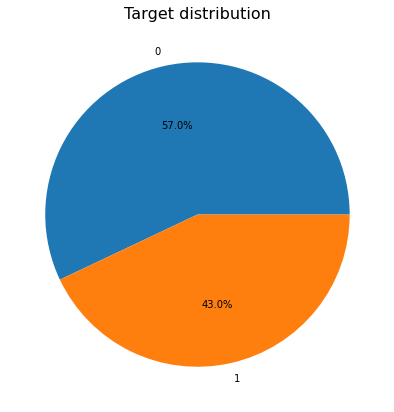

In [23]:
df_target = df.groupby(["target"])["id"].nunique()
ax = df_target.plot(kind="pie", figsize=(7,7), autopct="%1.1f%%")
ax.set_title("Target distribution", size=16)
ax.set_ylabel("")

The training dataset is **slightly unbalanced**, with a base rate of 57% for non-disaster tweets.

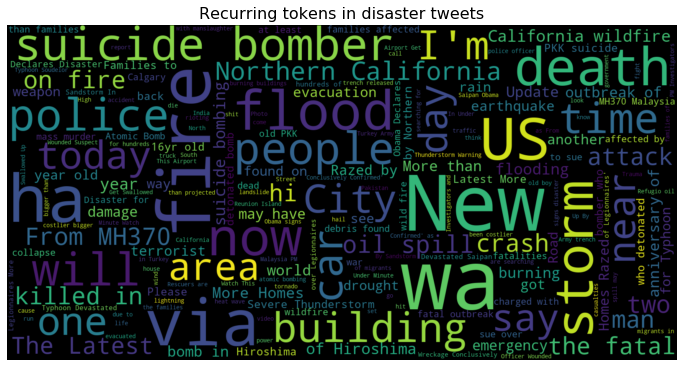

In [0]:
from wordcloud import WordCloud

disaster_tweets = df[df["target"]==1]["text"]

wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(disaster_tweets.str.cat(sep=" "))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Recurring tokens in disaster tweets", size=16)
plt.show()

This **word cloud** as well as the table below help us to visualize the **most recurring words and expressions** in disaster tweets.

It is also interesting to note that some tokens such as "suicide bomber", "Northern California" and "California wilfdire" seem to be **clear indicators of disaster**, since they mostly appear in disaster tweets. This led us to think that it might be worthwhile to include 2-gram tokens during tokenization.

In [0]:
from notebook_functions import token_counter

df_tokens = token_counter(df, ngram_range=(2,2))
df_tokens.sort_values(by="TOTAL", ascending=False).iloc[:10]

,Nothing,Disaster,TOTAL
burning buildings,23,37,60
suicide bomber,0,59,59
northern california,0,41,41
liked video,34,7,41
cross body,39,1,40
oil spill,1,38,39
suicide bombing,1,35,36
year old,6,28,34
california wildfire,0,34,34
looks like,21,12,33


## Tokenization and vectorization

To get a representation of data that machine learning models can work with, tweets first need to be **vectorized**. After the data has been fitted onto the vectorizer, we obtain a bag-of-words matrix containing either token counts or token TF-IDF values for each tweet, depending on the chosen type of vectorizer. One should also select how many **grams** tokens should composed be of.

In order to make it more convenient to experiment with our models, we created a **custom function** allowing us to switch between vectorization types, as well as to specify the number of grams and any tokens we might want to exclude post-cleaning.

In [6]:
from notebook_functions import create_vectorizer

vectorizer = create_vectorizer(mode="count",  # "count" or "tfidf"
                               ngram_range=(1,1), 
                               remove_tokens=[])

X = vectorizer.fit_transform(df["text"].values.tolist())
y = df["target"].values.tolist()

X

<7613x11819 sparse matrix of type '<class 'numpy.int64'>'
	with 59059 stored elements in Compressed Sparse Row format>

In [0]:
# print(vectorizer.get_feature_names())

## Models

### General process

In an attempt to build a good model, we went back to classifiers previously seen in the Data Mining & Machine Learning and Big-Scale Analytics courses.

In the first test phase, we trained them without tweaking hyperparameters too much in order to **compare how they generally performed** with this particular dataset. The classifiers that we included in the trials were:

* Random forest
* XGBoost
* Logistic regression (with built-in cross-validation)
* Support vector machines: SVC, NuSVC, SGDClassifier
* Naive Bayes: Bernoulli, Gaussian, multinomial
* Neural network

The first two quickly turned out to be much less effective than the others, which is why we excluded them from later tests. As for the various SVM and naive Bayes classifiers, we kept only NuSVC and Bernoulli because they were consistently giving us better results.

Because of the complexity of its parametrization, the neural network was tested separately by a member of our team.

The second test phase consisted of trying various **cleaning and vectorization strategies**. Here, we observed how keeping, removing, or changing certain types of tokens affected the scores.

In the last test phase, we **tuned the hyperparameters** of the three best-performing classifiers by running a grid search, then merged them into an **ensemble classifier**.

Model evaluation was done with **F1 scores** (i.e., the harmonic mean of precision and recall), since it is the same metric as the one used by Kaggle to evaluate submissions.

### Train, validation and test sets

We **split** the clean data into a training and testing set with a 70/30 ratio. We extracted two thirds of the testing set to create a **validation set**, which we used for hyperparameter tuning. That way, we could avoid the overfitting that would occur if we tuned the parameters according to the training set.

In order to get reproducible and comparable results, we arbitrarily chose a **random seed** to be used as a parameter for the train/validation/test split and for model training.

In [7]:
from sklearn.model_selection import train_test_split

RSEED = 42

train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1-train_ratio), random_state=RSEED)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=(test_ratio/(test_ratio + val_ratio)), random_state=RSEED) 

### Training

This section corresponds to the **training phase** of our best-performing classifiers (i.e., NuSVC, Bernoulli naive Bayes and logistic regression) and their combination into a **voting classifier**. It is possible to run this code with or without hyperparameter tuning (setting `hyperparameter_tuning` to "True" or "False", respectively).

In [8]:
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

hyperparameter_tuning = False

#### Classifier 1: NuSVC

In [9]:
from sklearn.svm import NuSVC

if hyperparameter_tuning:
    gs_svc = GridSearchCV(NuSVC(probability=True, random_state=RSEED),
                      param_grid={
                          "kernel": ["rbf", "poly"],
                          "nu": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
                          "gamma": ["scale", 0.1, 0.2, 0.3]
                      })
    gs_svc.fit(X_val, y_val)

    svc_scores = gs_svc.cv_results_
    kernel = gs_svc.best_params_["kernel"]
    nu = gs_svc.best_params_["nu"]
    gamma = gs_svc.best_params_["gamma"]
else:
    kernel = "rbf"
    nu = 0.5
    gamma = 0.1

print("Best parameters:")
print("\tkernel =", kernel)
print("\tnu =", nu)
print("\tgamma =", gamma)

clf1 = NuSVC(kernel=kernel, nu=nu, gamma=gamma, probability=True, random_state=RSEED)
clf1.fit(X_train, y_train)
f1_score(y_test, clf1.predict(X_test))

Best parameters:
	kernel = rbf
	nu = 0.5
	gamma = 0.1


0.7745098039215685

Text(0.5, 0.98, 'NuSVC: Adjusting nu / gamma on RBF kernel')

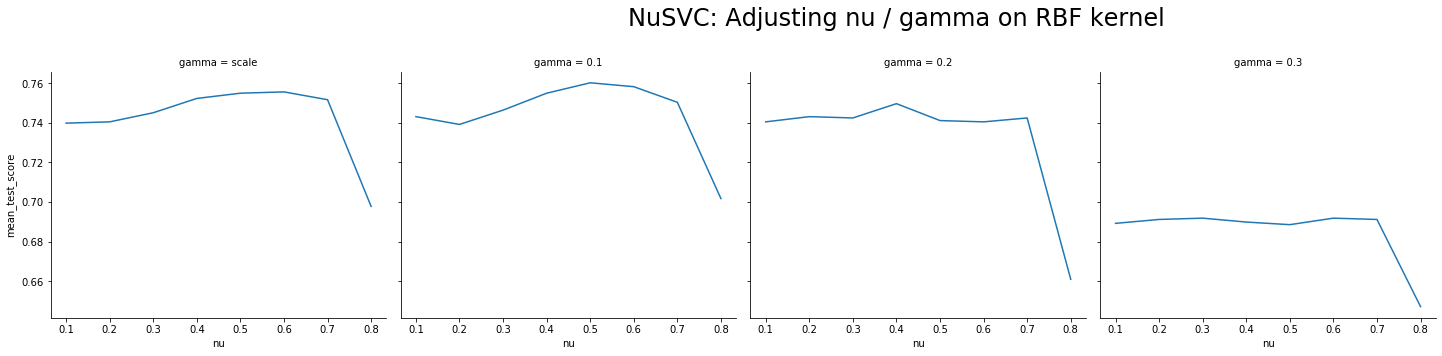

In [31]:
plot_df = pd.DataFrame(svc_scores["params"])
plot_df["mean_test_score"] = svc_scores["mean_test_score"]
g = sns.FacetGrid(plot_df[plot_df["kernel"]=="rbf"], col="gamma", col_wrap=5, height=5)
g = g.map(plt.plot, "nu", "mean_test_score")
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("NuSVC: Adjusting nu / gamma on RBF kernel", fontsize=24)

Text(0.5, 0.98, 'NuSVC: Adjusting nu / gamma on polynomial kernel')

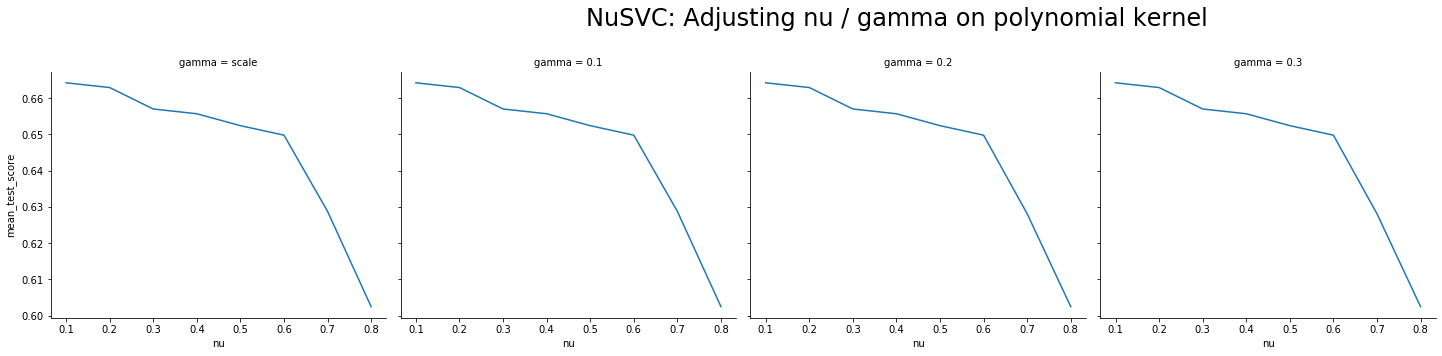

In [32]:
g = sns.FacetGrid(plot_df[plot_df["kernel"]!="rbf"], col="gamma", col_wrap=5, height=5)
g = g.map(plt.plot, "nu", "mean_test_score")
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("NuSVC: Adjusting nu / gamma on polynomial kernel", fontsize=24)

As the first series of graphs above shows, the model's performance decreases as $\gamma$ (the kernel coefficient) increases. No matter the value of $\gamma$, the sweet spot for $\nu$ seems to be in the **0.4 to 0.6 range**. Choosing "scale" over a value of 0.1 for $\gamma$ seems to be a moot point.

The model performs significantly **worse with the polynomial kernel function**, and the adjustment of $\gamma$ does not seem to make any difference.

#### Classifier 2: Bernoulli naive Bayes

In [23]:
from sklearn.naive_bayes import BernoulliNB

if hyperparameter_tuning:
    gs_nb = GridSearchCV(BernoulliNB(),
                      param_grid={
                          "alpha": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                          "fit_prior": [False, True]
                      })
    gs_nb.fit(X_val, y_val)
    
    nb_scores = gs_nb.cv_results_
    alpha = gs_nb.best_params_["alpha"]
    fp = gs_nb.best_params_["fit_prior"]
else:
    alpha = 0.5
    fp = False

print("Best parameters:")
print("\talpha =", alpha)
print("\tfit_prior =", fp)

clf2 = BernoulliNB(alpha=alpha, fit_prior=fp)
clf2.fit(X_train, y_train)
f1_score(y_test, clf2.predict(X_test))

Best parameters:
	alpha = 0.5
	fit_prior = False


0.7791798107255521

Text(0.5, 0.98, 'Bernoulli NB: Adjusting alpha / fit_prior')

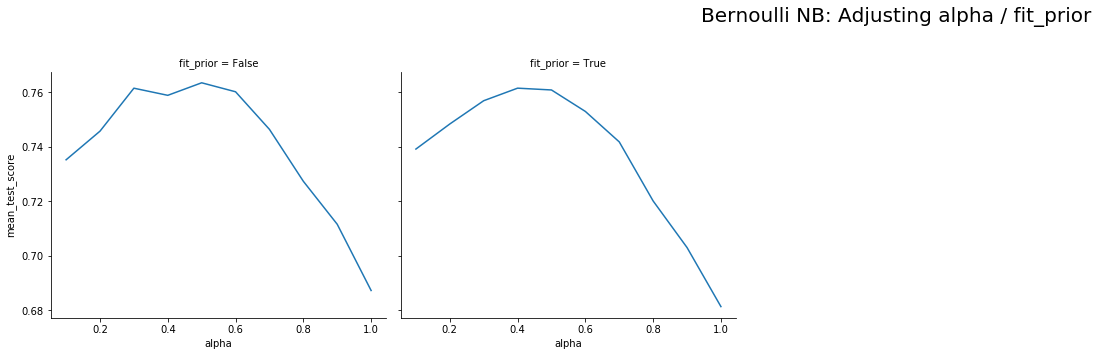

In [33]:
plot_df = pd.DataFrame(nb_scores["params"])
plot_df["mean_test_score"] = nb_scores["mean_test_score"]
g = sns.FacetGrid(plot_df, col="fit_prior", col_wrap=5, height=5)
g = g.map(plt.plot, "alpha", "mean_test_score")
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("Bernoulli NB: Adjusting alpha / fit_prior", fontsize=20)

Learning the class prior probabilities does not play a major role in the model's performance. In both cases, good values for $\alpha$ lie between **0.3 and 0.6**.

#### Classifier 3: Logistic regression

In [35]:
from sklearn.linear_model import LogisticRegressionCV

if hyperparameter_tuning:
    gs_lr = GridSearchCV(LogisticRegressionCV(cv=5, max_iter=2000, random_state=RSEED),
                      param_grid={
                          "solver": ["newton-cg", "lbfgs"],
                          "fit_intercept": [False, True]
                      })
    gs_lr.fit(X_val, y_val)

    lr_scores = gs_lr.cv_results_
    solver = gs_lr.best_params_["solver"]
    fi = gs_lr.best_params_["fit_intercept"]

else:
    solver = "newton-cg"
    fi = True

print("Best parameters:")
print("\tsolver =", solver)
print("\tfit_intercept =", fi)

clf3 = LogisticRegressionCV(solver=solver, fit_intercept=fi, cv=5, max_iter=2000, random_state=RSEED)
clf3.fit(X_train, y_train)
f1_score(y_test, clf3.predict(X_test))

Best parameters:
	solver = newton-cg
	fit_intercept = True


0.7765089722675367

Text(0.5, 1.0, 'Logistic regression with CV: Adjusting solver / fit_intercept')

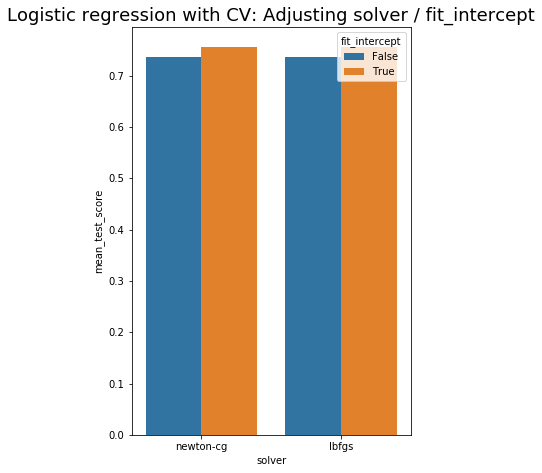

In [40]:
plot_df = pd.DataFrame(lr_scores["params"])
plot_df["mean_test_score"] = lr_scores["mean_test_score"]
fig, ax = plt.subplots(figsize=(5, 7.5))
ax = sns.barplot(x="solver", y="mean_test_score", data=plot_df, hue="fit_intercept", ax=ax)
ax.set_title("Logistic regression with CV: Adjusting solver / fit_intercept", size=18)

In our case, the choice of solver for the optimization problem **does not matter**. The `fit_intercept`, on the other hand, should be set to "True" for higher performance. 

#### Ensemble classifier: Let's vote!

In [0]:
from sklearn.ensemble import VotingClassifier

clf = VotingClassifier(estimators=[("nusvc", clf1), ("bern", clf2), ("lr", clf3)], voting="soft")
clf.fit(X_train, y_train)
f1_score(y_test, clf.predict(X_test))

0.7828843106180666

### Results

#### Impact of cleaning and vectorization

We performed several tests in order to determine the **best cleaning and vectorization strategy**. To make sure the resulting effects were not tied to a specific model, we ran these tests using the three classifiers above (always with the same settings). Note that the tests were done before the implementation of the `split_hashtags` operation.

The test results are displayed in the table below:

In [0]:
url = "https://github.com/XaviJunior/SBB/blob/master/project_2/Data/cleaning_tests.xlsx?raw=true"
results = pd.read_excel(url, sheet_name=None)
results["cleaning_tests"].loc[:,["remove_numbers", "remove_users", "remove_rt", "remove_elongated", "remove_punctuation", "bow", "model", "score"]]

,remove_numbers,remove_users,remove_rt,remove_elongated,remove_punctuation,bow,model,score
0,False,False,False,False,False,tfidf,NuSVC,0.728086
1,False,False,True,False,False,tfidf,NuSVC,0.728086
2,False,True,True,False,False,tfidf,NuSVC,0.732095
3,True,True,True,False,False,tfidf,NuSVC,0.729537
4,True,True,True,False,True,tfidf,NuSVC,0.735816
5,True,True,True,True,True,tfidf,NuSVC,0.732444
6,False,False,False,False,False,count,NuSVC,0.735733
7,False,False,True,False,False,count,NuSVC,0.732865
8,False,True,True,False,False,count,NuSVC,0.729825
9,True,True,True,False,False,count,NuSVC,0.732568


From these numbers, it is quite obvious that the optional cleaning operations had **very little to no effect** on the accuracy of our models. The difference between the minimum and maximum scores for each specific classifier does not go much beyond 0.7%.

Moreover, there seems to be **no clear trend** which is valid across all models. Sometimes, running an additional operation has a positive effect (e.g. going from row 3 to row 4), while doing the same operation with another model/vectorization type yields a negative result (e.g. from row 15 to row 16).

Still, some **interesting observations** can be made:

* With Bernoulli naive Bayes, it does not matter whether one uses TF-IDF or count vectorization. As far as the other two are concerned, logistic regression seems to perform slightly better with the former; and NuSVC, with the latter.
* Removing the "RT" keyword mostly has no effect.
* Except for NuSVC with count vectorization, removing usernames is generally beneficial to the models. 
* Replacing elongated words has a mostly positive effect, except in the case of NuSVC with TF-IDF.
* Removing punctuation is indicated for NuSVC and logistic regression, not for Bernoulli naive Bayes.
* [not captured by this table] Model accuracy decreases as the number of grams increases.

The best test score (73.59%) was achieved by **NuSVC** with **count** vectorization, and applying **all optional cleaning operations**. The funny thing is that, in this case, applying none of these operations yielded almost the same result. This leads us to question whether any of these cleaning tests can really be trusted. What is more, the fact the we ended up building an ensemble consisting of all three classifiers puts the importance of these results into perspective.

Eventually, we decided to go with **all cleaning operations** and **count vectorization**, because they made the most sense to us and are the ones that we would implement in a real application. That being said, judging by how we are struggling to improve the accuracy of our models, we are confident that we are **missing some cleaning steps** which would help us to get better scores.

#### Model performance and parametrization

On a given training set, **Bernoulli naive Bayes** always seems to be giving the best scores, while NuSVC and logistic regression perform more or less equally. Thankfully, having an ensemble classifier relieves us of having to choose between one or the other.

The Bernoulli classifier has the other advantage of having **near-instant training time** and very few parameters to adjust (`binarize` has no effect here).

Note that because we wanted to work with **probabilities** in later steps (see _Explanations with LIME_ and _What if we augment the data?_ ), we needed to change the `probability` parameter of NuSVC to "True", and the `voting` parameter of our ensemble classifier to "soft".

All in all, our various tests consistently gave us scores in the **78-80% range**, which is well above the base rate (57%) and thus a satisfying result.

### Using a more complex model: The neural network

Because neural networks are often hailed as the Holy Grail of machine learning classifiers, we decided to give it a go. However, they are known to be much more complex, and their parametrization is no easy task. As a starting point, we used a **3-layer architecture**, like the one seen in last semester's course as well as in many online tutorials.

```
NN.add(Dense(512, input_shape=(N,), activation="relu"))
NN.add(Dropout(0.5))
NN.add(Dense(256, activation="relu"))
NN.add(Dropout(0.5))
NN.add(Dense(2, activation="sigmoid"))
```

After many trials tuning the hyperparameters (i.e. the loss, optimizer and activation functions, as well as the batch size and number of epochs), we realized that something was wrong: our model had **way too much overfitting**, and scores given by Kaggle were significantly worse than those achieved by other models (about 4 to 5% lower).

After reading about neural network overfitting in [this article](https://keras.rstudio.com/articles/tutorial_overfit_underfit.html), we "lightened" the model by **drastically lowering the output shape** (32/16/2 instead of 512/256/2). This rework had the effect of improving our score by almost 2%, along with less overfitting and a much faster computation speed (which also made the adjustment of hyperparameters easier). 

By further tuning the aforementioned parameters (and the type of vectorizer), we were able to increase the F1 score by an additional percent. However, the model is still **underperforming** compared to the ones previously seen.

In [0]:
from keras.utils import to_categorical

X = df["text"]
y = df["target"]

vectorizer = create_vectorizer(mode="count",  # "count" or "tfidf"
                               ngram_range=(1,6), 
                               remove_tokens=[])

X = vectorizer.fit_transform(df["text"].values.tolist())
y = to_categorical(df["target"].values.tolist())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)

In [0]:
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import np_utils

from notebook_functions import precision_m, recall_m, f1_m

NN = Sequential()
NN.add(Dense(32, input_shape=(X_train.shape[1],), activation="relu"))
NN.add(Dropout(0.5))
NN.add(Dense(16,activation="relu"))
NN.add(Dropout(0.5))
NN.add(Dense(2, activation="sigmoid"))
NN.summary()

NN.compile(loss="binary_crossentropy",
           optimizer="adam",
           metrics=["accuracy", f1_m, precision_m, recall_m])

NN.fit(X_train, y_train,
       batch_size=512,
       epochs=20,
       verbose=0,
       validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                5311712   
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 34        
Total params: 5,312,274
Trainable params: 5,312,274
Non-trainable params: 0
_________________________________________________________________


#### Model evaluation

In [0]:
# Model evaluation
accuracy, loss, precision, recall, f1_score = NN.evaluate(X_test, y_test, verbose=0)

print("Accuracy:", accuracy)
print("Loss:", loss)
print("Precision:", precision)
print("Recall=", recall)
print("F1 score:", f1_score)

Accuracy: 0.5567171347822238
Loss: 0.7859488129615784
Precision: 0.785851240158081
Recall= 0.7828642725944519
F1 score: 0.7889940142631531


## Getting predictions

### Explanations from LIME

Before turning our predictions over to Kaggle, we wanted to ask ourselves: is our classifier making its decisions **based on sound reasoning**? For that purpose, we used one of the explainable AI tools that we studied during our first project, namely LIME (which stands for Local Interpretable Model-agnostic Explanations).

This library allows the user to visualize the **weight** that each token of a given tweet has on the prediction's outcome, as well as the **prediction probabilities** (in other words, the level of confidence of the model).

Below is an example of a **LIME explanation** for one of the tweets. We see that the word **eBay** has the biggest impact on the prediction. Since this tweet comes from the test set provided by Kaggle, we do not know its target class for sure, but judging from its contents, we are quite confident that our model is correct, and that the word "eBay" is indeed a dead giveaway of a non-disaster tweet (even in the presence of words like "ambulance").

In [0]:
from notebook_functions import lime_plot

lime_plot(classifier=clf, vectorizer=vectorizer, 
          tweet=df_test["text"][77],
          num_features=8)

![alt text](https://i.ibb.co/K0TZ8Kz/lime-plot.png)

### Export

Based on our model, we **compute predictions** for the entire test set provided by Kaggle. Before doing that, we **fit the whole data** to the model in the hope of increasing its accuracy.

The function below enables the export of data in the format required by Kaggle (a CSV file containing each tweet's `id` and its predicted `target`) so that we can submit our predictions. It also saves a version of the **test set with the predicted classes**, as well as the **probabilities** of those predictions. These two variables are needed for the last (optional) step.

In [0]:
from notebook_functions import get_predictions

df_test_preds, proba = get_predictions(classifier=clf,
                                       vectorizer=vectorizer,
                                       to_fit=(X, y),
                                       test_data=df_test,
                                       test_name="GS_VC",
                                       export=True)

Predictions exported to GS_VC.csv


### What if we augment the data?

With all the different combinations of cleaning, vectorization and classifiers that we tried, we deem our approach satisfactory. Unfortunately, they have had **little impact on our Kaggle score**. In an attempt to improve it, we resorted to a quick-and-dirty (mostly dirty) method which consists of **artificially augmenting** the original dataset (`train.csv`) with tweets from the test set where the probabilities of our model's predictions were above a certain threshold. The model was then fitted with the augmented `X` and `y` before exporting the new predictions.

Of course, this leads to **model overfitting**, but as it turns out, it _did_ indeed improve our score (albeit marginally, by about 0.5%).

This method was interesting to experiment with, but it should _not_ be kept in the final application. 

In [0]:
from notebook_functions import augment_dataset

X_augm, y_augm = augment_dataset(fitted_classifier=clf,
                                 vectorizer=vectorizer,
                                 cleaning_args=cleaning_args,
                                 test_data_with_predictions=df_test_preds,
                                 probabilities=proba,
                                 threshold=0.7)

df_test_preds, proba = get_predictions(classifier=clf,
                                       vectorizer=vectorizer,
                                       to_fit=(X_augm, y_augm),
                                       test_data=df_test,
                                       test_name="GS_VC_augm",
                                       export=True)

Predictions exported to GS_VC_augm.csv


## Conclusion

With the combined power of three classifiers, we have been able to build a model that can predict whether tweets talk about disasters or not. According to Kaggle, our model reaches a F1 score of **82.5%**, which is well above the baseline approach.

While the result is already quite good, there is still room for improvement. We suspect that a more aptly engineered **neural network** along with Doc2Vec representation, as well as **additional cleaning operations** could help in that regard. 